In [1]:
import db
import networkx as nx
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

In [5]:
import os
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@11/"

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/local/opt/openjdk@11/"

In [3]:
from pyspark import *
from pyspark.sql import *
from graphframes import *
import findspark

findspark.init("./spark-3.2.0-bin-hadoop3.2")

# Start a Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/18 19:47:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
21/11/18 19:47:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/11/18 19:47:13 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
21/11/18 19:47:13 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
21/11/18 19:47:13 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [4]:
connection = db.connect()
cursor = connection.cursor()

In [5]:
cursor.execute("""
    SELECT d1.officer_id src, d2.officer_id dst, COUNT(*) shifts_worked
    FROM data_officerassignmentattendance d1
        JOIN data_officerassignmentattendance d2 
        ON d1.start_timestamp = d2.start_timestamp 
            AND d1.beat_id = d2.beat_id 
            AND d1.officer_id < d2.officer_id
    WHERE d1.present_for_duty AND d2.present_for_duty
    GROUP BY d1.officer_id, d2.officer_id;
""")
tsedges = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [6]:
cursor.execute("""
    SELECT t1.officer_id src, t1.subject_race sub_race,
            t2.officer_id dst, COUNT(DISTINCT t1.event_id)
    FROM trr_trr t1
        JOIN trr_trr t2 ON t1.event_id = t2.event_id AND t1.officer_id < t2.officer_id
    GROUP BY t1.officer_id, t2.officer_id, t1.subject_race
    ORDER BY count(DISTINCT t1.event_id) DESC;
""")
edges = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
edges

,src,sub_race,dst,count
0,17634,BLACK,29992,18
1,1444,BLACK,29209,16
2,3802,BLACK,23950,13
3,31898,BLACK,32428,13
4,15767,BLACK,29529,13
...,...,...,...,...
30666,1440,BLACK,18850,1
30667,1444,BLACK,20939,1
30668,1444,BLACK,23786,1
30669,1444,BLACK,27929,1


In [7]:
set(edges['sub_race'])

{'ASIAN/PACIFIC ISLANDER',
 'BLACK',
 'HISPANIC',
 'NATIVE AMERICAN/ALASKAN NATIVE',
 None,
 'WHITE'}

In [8]:
cursor.execute("""
    SELECT  id, first_name || ' ' || last_name "name", trr_count, race
    FROM data_officer
    WHERE id IN (SELECT DISTINCT  officer_id FROM trr_trr);
""")
nodes = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
nodes

,id,name,trr_count,race
0,32312,Randall Ryan,4,White
1,32358,Kevin Stoll,5,White
2,32461,Albert Krueger,1,White
3,15636,Marie Lane,1,White
4,31793,Adam Aleszczyk,4,White
...,...,...,...,...
10793,32398,Thomas Waldera,1,White
10794,32098,Christoph Kennedy,2,White
10795,25503,Christ Savickas,7,White
10796,25732,Andrew Schoeff,1,White


In [9]:
nodes['race'] = nodes['race'].str.upper().replace('ASIAN/PACIFIC', 'ASIAN/PACIFIC ISLANDER')
set(nodes['race'])

{'ASIAN/PACIFIC ISLANDER',
 'BLACK',
 'HISPANIC',
 'NATIVE AMERICAN/ALASKAN NATIVE',
 'WHITE'}

In [10]:
cross_race = edges.join(nodes.set_index('id'), on=['src'])
cross_race = cross_race.drop(columns=['name', 'trr_count'])
cross_race = cross_race.rename(columns = {'race': 'off_race'})
cross_race = cross_race[cross_race['off_race'] != cross_race['sub_race']]
cross_race

,src,sub_race,dst,count,off_race
0,17634,BLACK,29992,18,WHITE
1,1444,BLACK,29209,16,HISPANIC
2,3802,BLACK,23950,13,WHITE
3,31898,BLACK,32428,13,WHITE
4,15767,BLACK,29529,13,WHITE
...,...,...,...,...,...
30666,1440,BLACK,18850,1,WHITE
30667,1444,BLACK,20939,1,HISPANIC
30668,1444,BLACK,23786,1,HISPANIC
30669,1444,BLACK,27929,1,HISPANIC


In [11]:
edges_reverse = cross_race.copy(deep=True)
edges_reverse['tmp'] = edges_reverse['src']
edges_reverse['src'] = edges_reverse['dst']
edges_reverse['dst'] = edges_reverse['tmp']
edges_reverse = edges_reverse.drop(columns=['tmp'])
edges_reverse

,src,sub_race,dst,count,off_race
0,29992,BLACK,17634,18,WHITE
1,29209,BLACK,1444,16,HISPANIC
2,23950,BLACK,3802,13,WHITE
3,32428,BLACK,31898,13,WHITE
4,29529,BLACK,15767,13,WHITE
...,...,...,...,...,...
30666,18850,BLACK,1440,1,WHITE
30667,20939,BLACK,1444,1,HISPANIC
30668,23786,BLACK,1444,1,HISPANIC
30669,27929,BLACK,1444,1,HISPANIC


In [12]:
aedges = pd.concat([edges, edges_reverse])
aedges = aedges.drop(columns=['sub_race', 'off_race'])
aedges

,src,dst,count
0,17634,29992,18
1,1444,29209,16
2,3802,23950,13
3,31898,32428,13
4,15767,29529,13
...,...,...,...
30666,18850,1440,1
30667,20939,1444,1
30668,23786,1444,1
30669,27929,1444,1


In [13]:
pr = GraphFrame(
    spark.createDataFrame(nodes),
    spark.createDataFrame(aedges),
).pageRank(resetProbability=0.15, tol=0.01)
pr.vertices.orderBy('pagerank', ascending=False).show()

+-----+-------------------+---------+--------------------+------------------+
|   id|               name|trr_count|                race|          pagerank|
+-----+-------------------+---------+--------------------+------------------+
|10583|     George Granias|       72|NATIVE AMERICAN/A...| 9.222648007773781|
|21371|    Phillip Orlando|       41|            HISPANIC| 8.846733152742393|
|32118|         Cesar Kuri|       65|            HISPANIC| 7.895960092092462|
|14400|      Patrick Kelly|       62|               WHITE|7.4211364356842635|
|28970|       Jeff Truhlar|       37|               WHITE| 6.699753594575394|
|31030|         Lucas Wise|       53|               WHITE| 6.583314895386835|
|20154|         Kevin Muth|       23|               WHITE| 6.351295091519219|
|16385|    Robert Lobianco|       59|               WHITE| 5.881354029277711|
|29670|     Adrian Vivanco|       64|            HISPANIC| 5.831543527526303|
|32271|        Paul Powers|       30|               WHITE|5.7984

In [14]:
pagerank = pr.vertices.toPandas().sort_values('pagerank', ascending=False)
pagerank

,id,name,trr_count,race,pagerank
10419,10583,George Granias,72,NATIVE AMERICAN/ALASKAN NATIVE,9.222648
4876,21371,Phillip Orlando,41,HISPANIC,8.846733
8791,32118,Cesar Kuri,65,HISPANIC,7.895960
415,14400,Patrick Kelly,62,WHITE,7.421136
3544,28970,Jeff Truhlar,37,WHITE,6.699754
...,...,...,...,...,...
7477,19701,Edward Morris,12,BLACK,0.193031
7482,4061,James Carter,3,BLACK,0.193031
7484,15093,John Kotarac,2,WHITE,0.193031
7485,5333,Stacey Cooper,4,BLACK,0.193031


In [69]:
pagerank[:1000].to_csv('pagerank_cross_race.csv', index=False)

In [15]:
triangles = GraphFrame(
    spark.createDataFrame(nodes),
    spark.createDataFrame(cross_race),
).triangleCount().toPandas()
triangles = triangles.sort_values(by=['count'], ascending=False)

In [16]:
triangles

,count,id,name,trr_count,race
10154,146,21371,Phillip Orlando,41,HISPANIC
514,134,32118,Cesar Kuri,65,HISPANIC
6969,133,13313,Steve Jarosz,20,WHITE
10370,132,10583,George Granias,72,NATIVE AMERICAN/ALASKAN NATIVE
6046,132,11615,Ryan Harty,22,WHITE
...,...,...,...,...,...
6996,0,21081,Daniel O Shea,4,WHITE
3032,0,15936,Lawrence Lee,3,BLACK
3033,0,2013,David Biggins,2,BLACK
3035,0,4312,Hector Centeno,4,HISPANIC


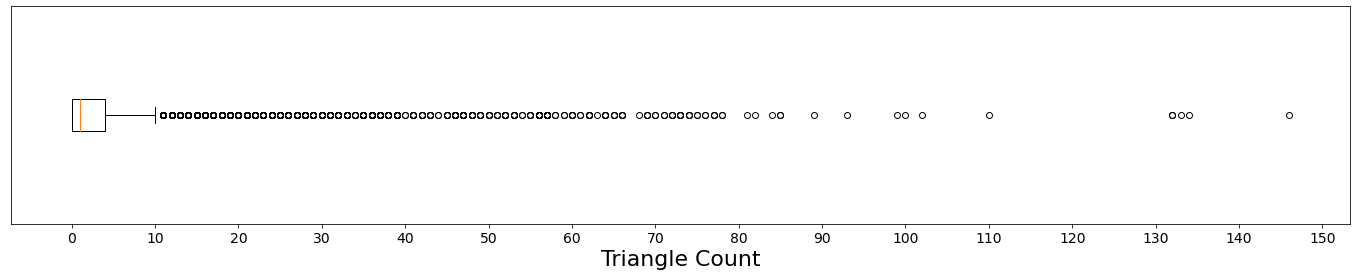

In [29]:
plt.figure(figsize=(24,4))
plt.boxplot(triangles['count'], vert=False)
plt.xticks(range(0,160,10), fontsize=14)
plt.yticks([])
plt.xlabel('Triangle Count', fontsize=22)
plt.show()

In [21]:
interested = set(triangles[:50]['id'])

In [23]:
def plot_graph(edges):
    plt.figure(figsize=(30,20))
    g = nx.Graph()
    g = nx.from_pandas_edgelist(edges, 'src', 'dst')
    nx.draw(g, with_labels=False, arrows=False, node_color='grey', node_size=50)
    plt.show()

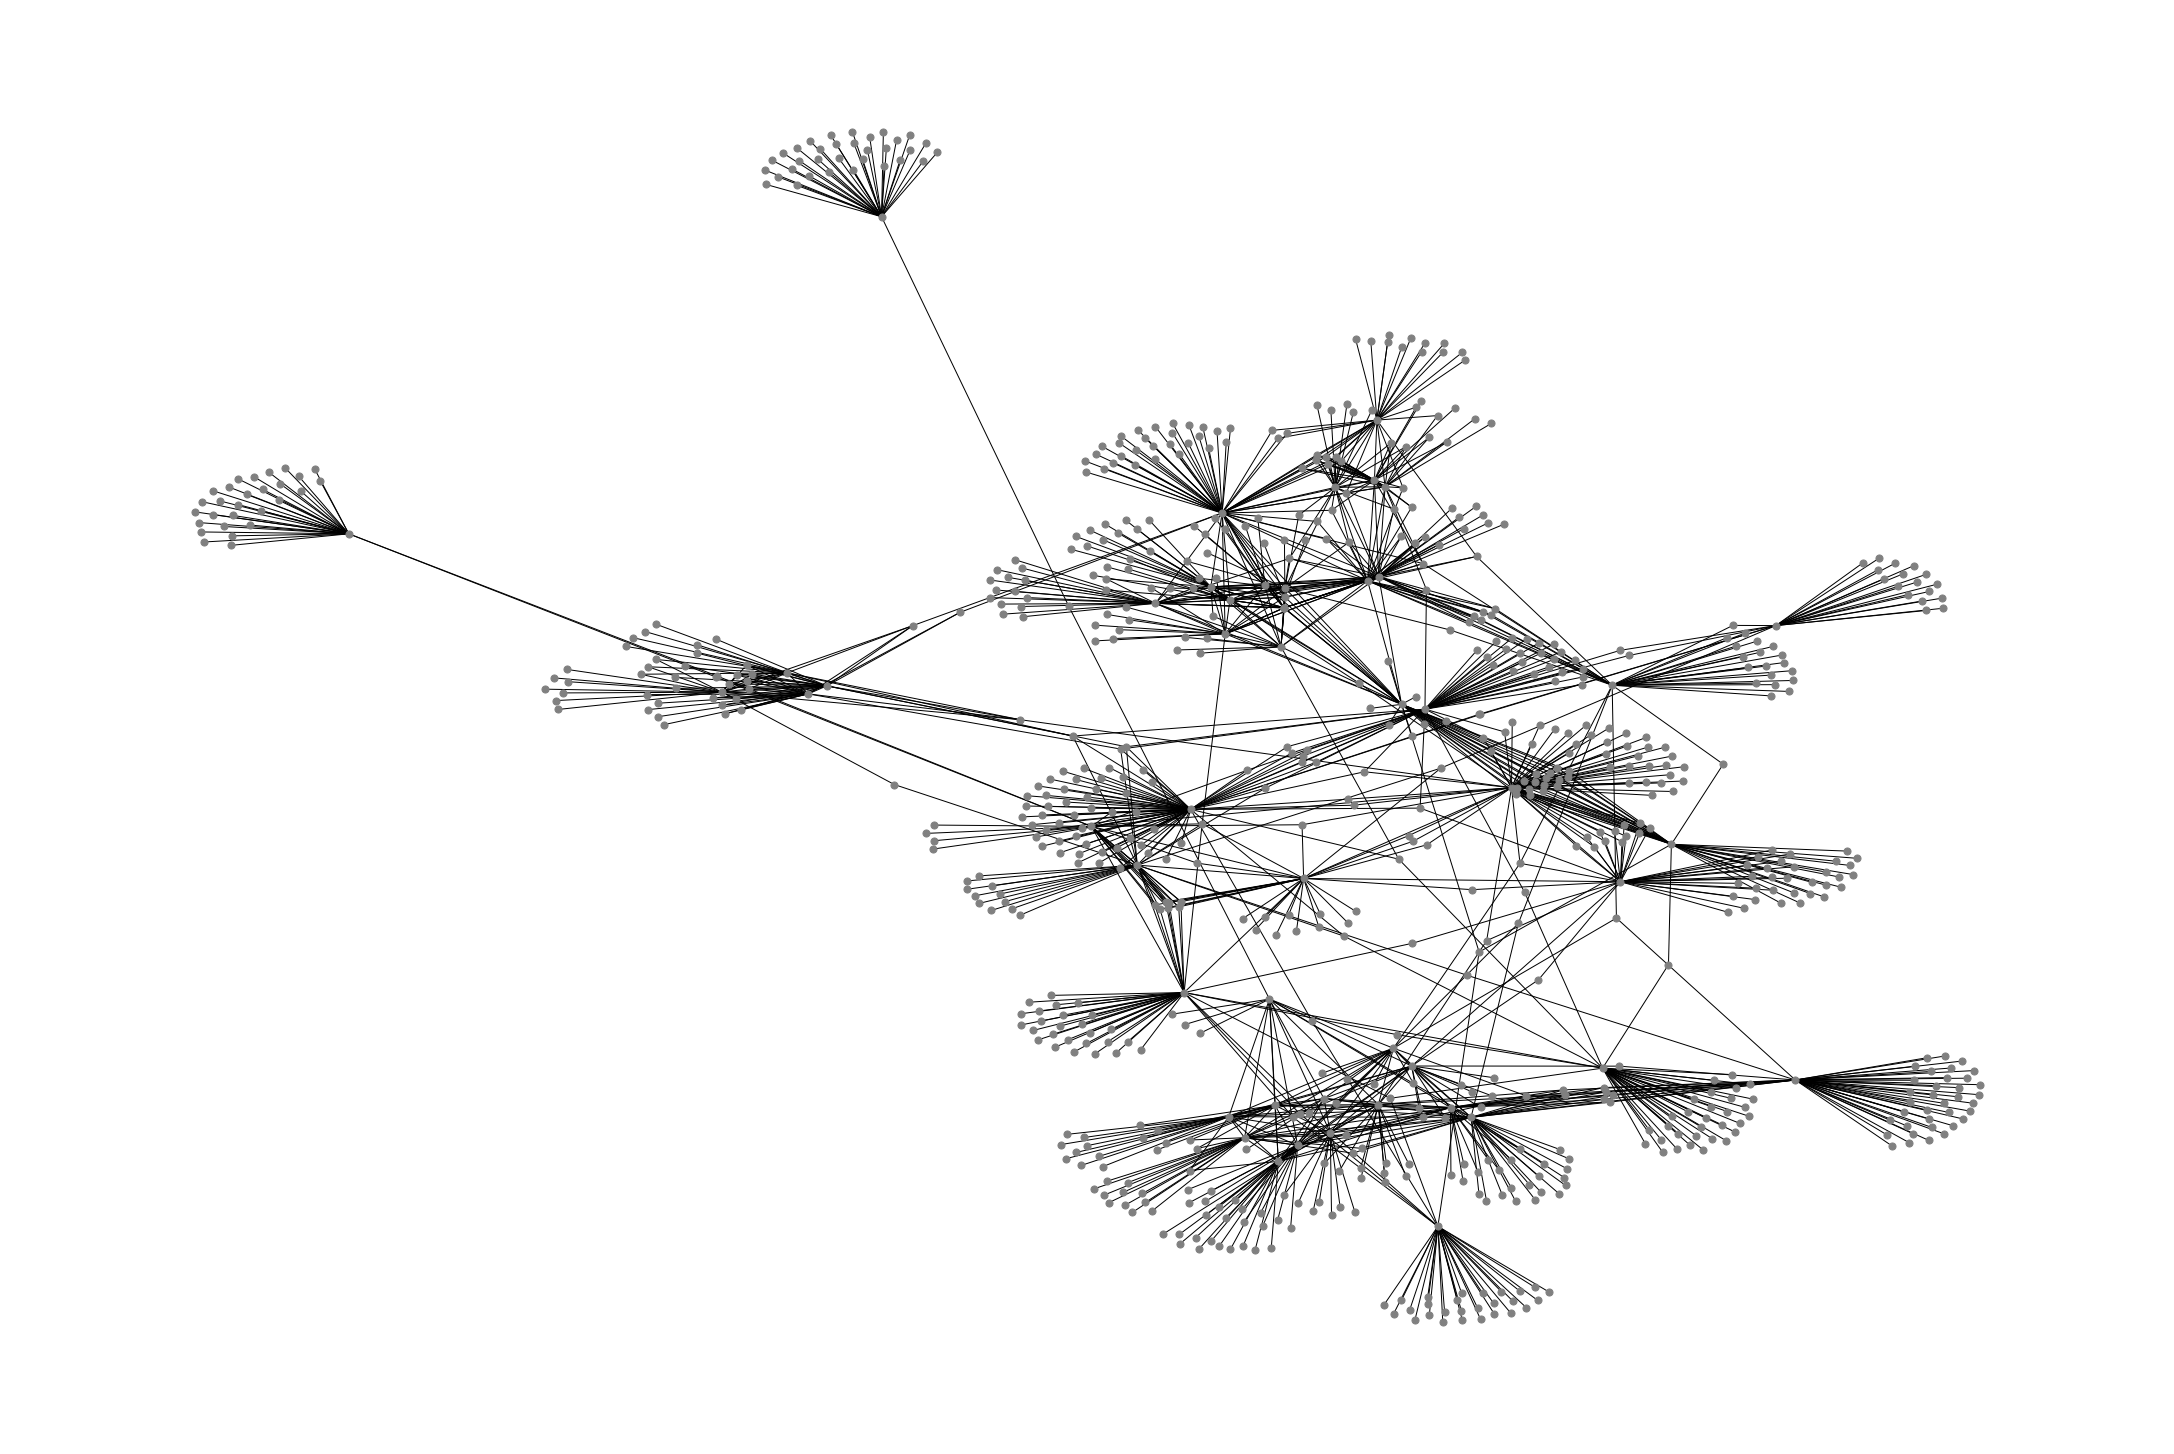

In [25]:
plot_graph(edges[(edges['src'].isin(interested)) | (edges['dst'].isin(interested))])

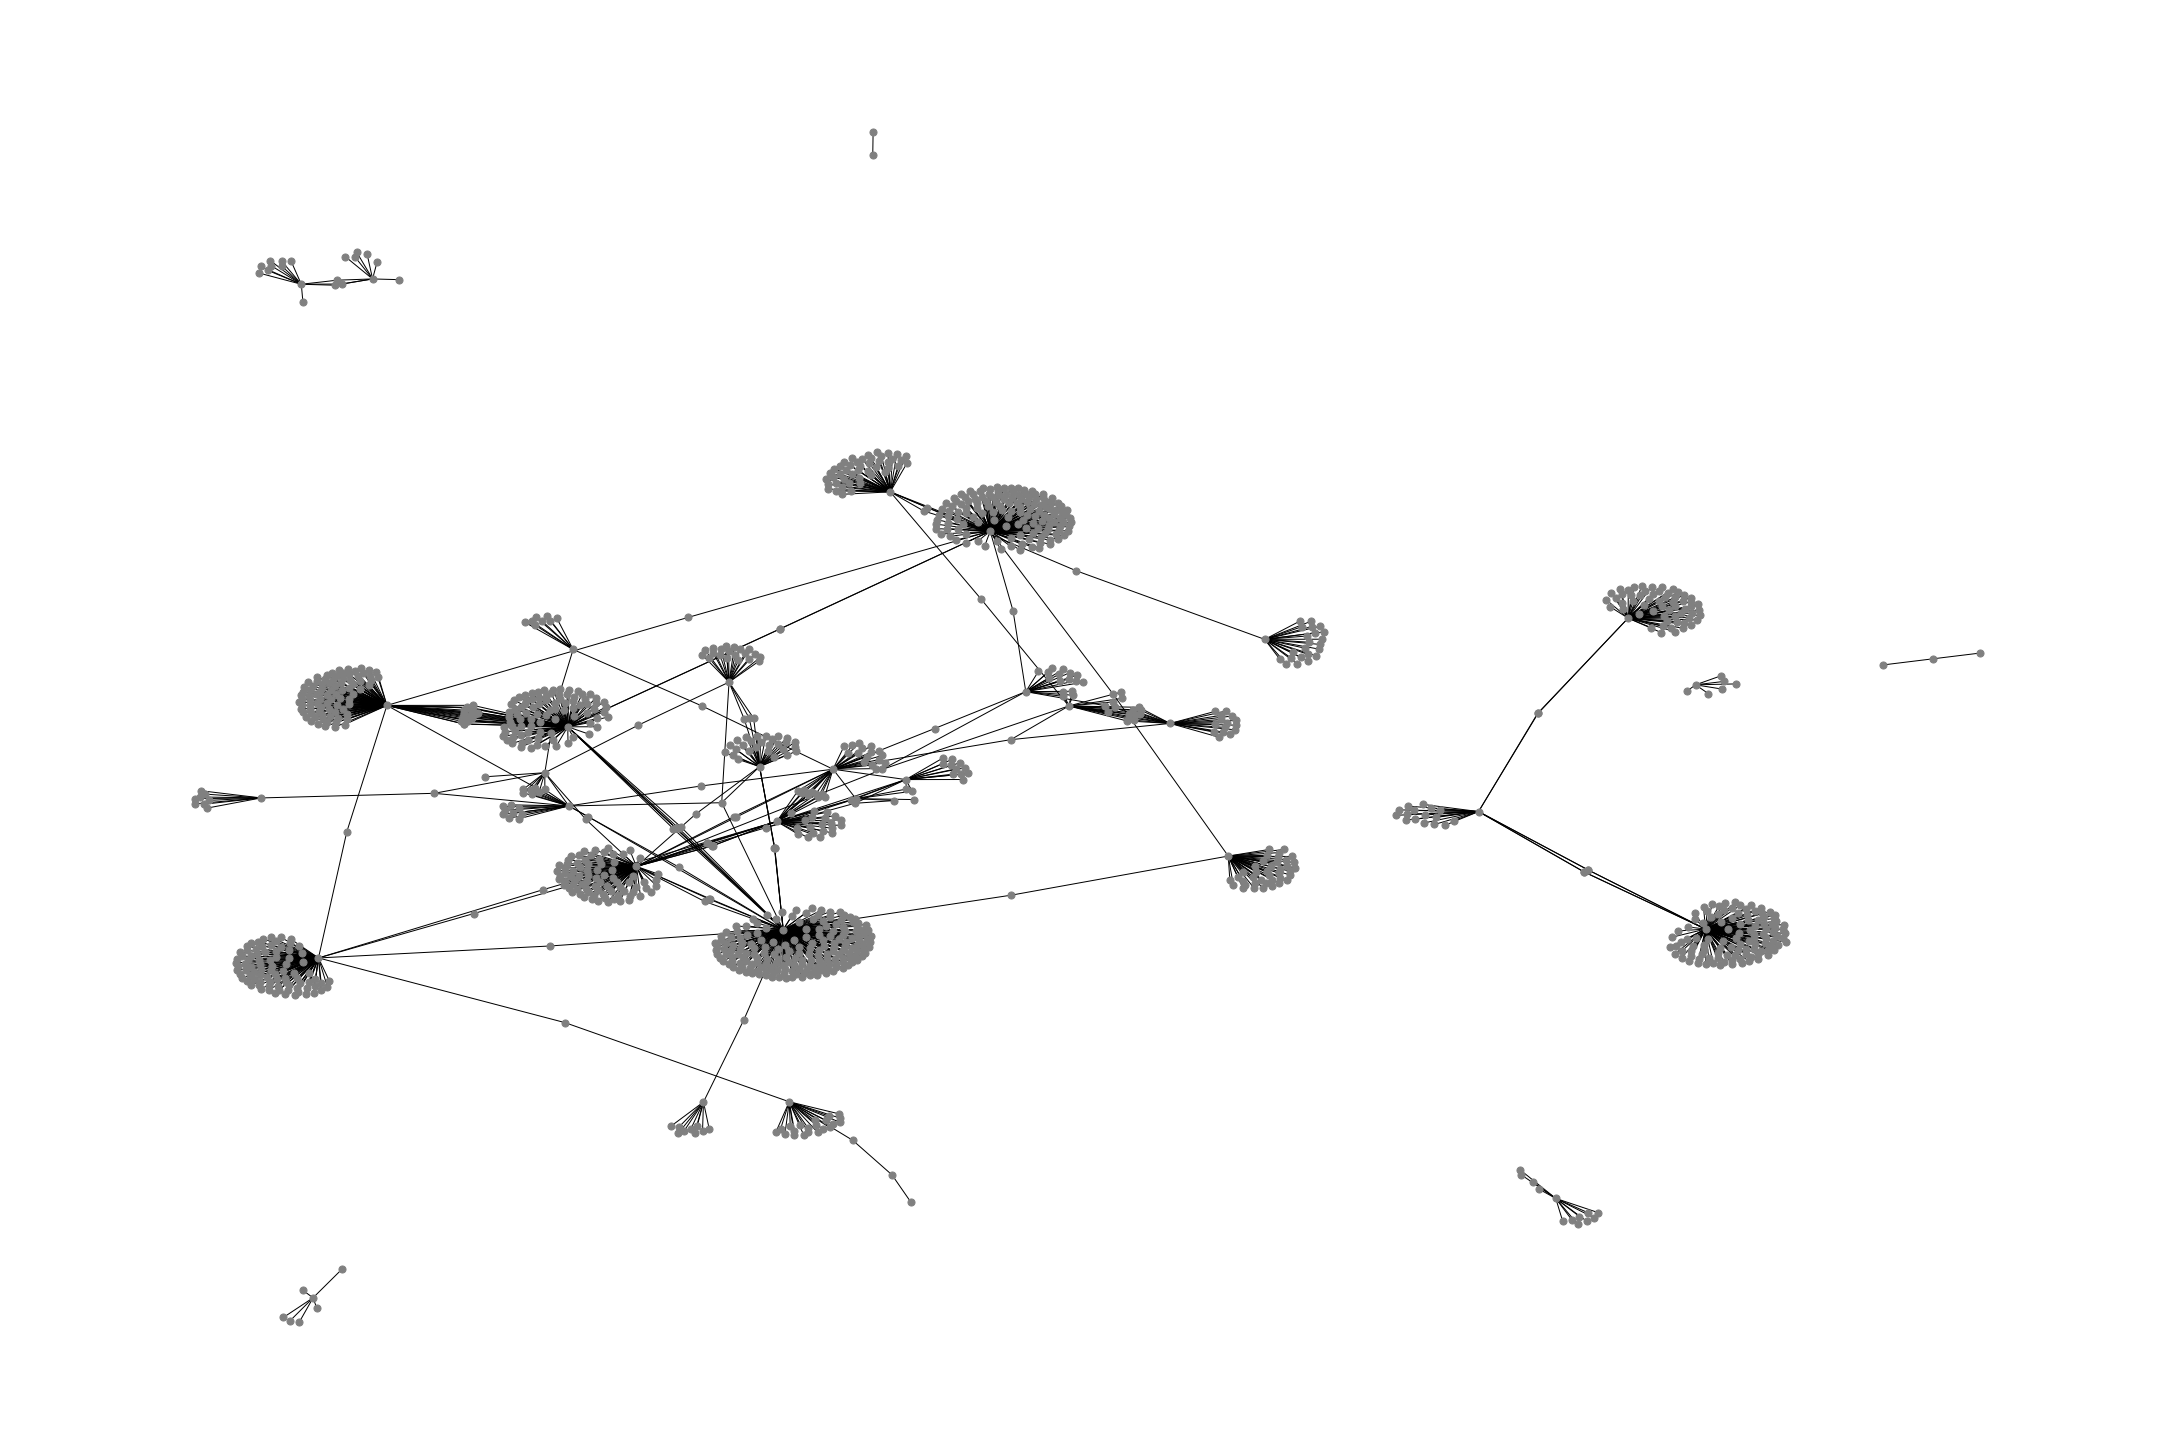

In [26]:
plot_graph(tsedges[(tsedges['src'].isin(interested)) | (tsedges['dst'].isin(interested))])